<a href="https://colab.research.google.com/github/hamidriasat/Natural-Language-Processing/blob/master/Hotel_Review_Prediction/Hotel_Reviews_XLnet_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install transformers libarary and pytorch
!pip install transformers
!pip install torch

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 890kB 15.8MB/s 
     |████████████████████████████████| 1.1MB 20.6MB/s 
     |████████████████████████████████| 2.9MB 29.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=364b20476f6dc572ac4c91b0f9cb8163160d0d6fc71846426708a067936f1da3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#  instal  langdetect to check text language
!pip install langdetect


     |████████████████████████████████| 983kB 2.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=e74ab3c9f8577498e6f3748028870853a7236166178215c333513ec092419943
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# make necessary imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


# from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
# from pytorch_transformers import AdamW
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import os
from collections import Counter
import json
from langdetect import detect




In [ ]:
# check gpu is available or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
#  download data set from website
!wget http://times.cs.uiuc.edu/~wang296/Data/LARA/TripAdvisor/TripAdvisorJson.tar.bz2


--2020-11-07 10:40:25--  http://times.cs.uiuc.edu/~wang296/Data/LARA/TripAdvisor/TripAdvisorJson.tar.bz2
Resolving times.cs.uiuc.edu (times.cs.uiuc.edu)... 192.17.58.170
Connecting to times.cs.uiuc.edu (times.cs.uiuc.edu)|192.17.58.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455746769 (435M) [application/x-bzip2]
Saving to: ‘TripAdvisorJson.tar.bz2’

TripAdvisorJson.tar 100%[===================>] 434.63M  91.3MB/s    in 5.7s    

2020-11-07 10:40:30 (76.3 MB/s) - ‘TripAdvisorJson.tar.bz2’ saved [455746769/455746769]



In [ ]:
# unzip data set
import shutil
shutil.unpack_archive("TripAdvisorJson.tar.bz2", "/content/")

In [ ]:
# to calculate moving average
def getAvg(prev_avg, x, n): 
    return ((prev_avg * 
             n + x) / 
            (n + 1)); 

# Perform Exploratory data analysis (EDA)
check total number of input reviews

average length of reviews 

In [ ]:

fileNames = os.listdir("json")
count= 0
avgContentLength = 0

ratings = []
for fileName in fileNames:
    with open(("json/"+fileName)) as file:
        fileData = json.load(file)
        for review in fileData["Reviews"]:
            if ('Content' in review and len(review['Content']) != 0 and 'Overall' in review["Ratings"] and len(review["Ratings"]['Overall']) != 0):
                content = review["Content"]
                rating = review["Ratings"]["Overall"]
                
                ratings.append(rating)
                avgContentLength = getAvg(avgContentLength, len(content.split()), count);
                count += 1
    
print("Total reviews")    
print(len(ratings))
print("Average length of each review")
print(avgContentLength)


Total reviews
1621956
Average length of each review
178.08645055722894


In [ ]:
#  get number of occurrences for each element
Counter( ratings )

Counter({'0': 1934,
         '0.0': 1,
         '1': 10194,
         '1.0': 99173,
         '2': 12083,
         '2.0': 103418,
         '3': 15626,
         '3.0': 195121,
         '4': 45357,
         '4.0': 463650,
         '5': 59923,
         '5.0': 615476})

In [ ]:
# Since 1.0 and 1  is same category so combine them
ratings = np.where(ratings== '0.0', 0, ratings) 
ratings = np.where(ratings== '1.0', 1, ratings) 
ratings = np.where(ratings== '2.0', 2, ratings) 
ratings = np.where(ratings== '3.0', 3, ratings) 
ratings = np.where(ratings== '4.0', 4, ratings) 
ratings = np.where(ratings== '5.0', 5, ratings) 
ratings = np.where(ratings== '0.0', 0, ratings) 

print((Counter(ratings)))


Counter({'5': 675399, '4': 509007, '3': 210747, '2': 115501, '1': 109367, '0': 1935})


# Now based on data
Because data is large so we cannot process it for now and that is not the requirement.

so read only 1935 instances of each class.  

We can do this by doing downsampling using sklearn library but since data is large so it's gonna give memory error.

So do it manually

In [ ]:
def replaceRating(rat):
    num = 0
    if(rat == "0.0" or rat == "0"):
        num= 0
    elif(rat == "1.0" or rat == "1"):
        num= 1
    elif(rat == "2.0" or rat == "2"):
        num= 2
    elif(rat == "3.0" or rat == "3"):
        num= 3
    elif(rat == "4.0" or rat == "4"):
        num= 4
    elif(rat == "5.0" or rat == "5"):
        num= 5
    return num

# Data Preprocessing
because of model requirement only read reviews of length of MAX_LEN

only read maxInstances reviews of each class

check that review language is english not any other

In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 200
# read limited data of each class
maxInstances = 1935


fileNames = os.listdir("json")
instances = [0,0,0,0,0,0]
contents= []
ratings = []
for fileName in fileNames:
    with open(("json/"+fileName)) as file:
        fileData = json.load(file)
        for review in fileData["Reviews"]:
            if ('Content' in review and len(review['Content']) != 0 and 'Overall' in review["Ratings"] and len(review["Ratings"]['Overall']) != 0):
                content = review["Content"]
                rating = review["Ratings"]["Overall"]
                rating = replaceRating(rating)
                
                if instances[rating] < maxInstances and detect(content) == ("en"):
                    ratings.append(rating)
                    instances[rating] += 1

                    templength= len(content.split() )
                    if templength < MAX_LEN:
                        contents.append(content)
                    else:
                        temp= ""
                        convert= content.split()
                        for j in range(0, MAX_LEN):
                            temp= temp+ " "+convert[j]
                        contents.append(temp)    
                    

    if (instances[0] + instances[1] + instances[2]+instances[3]+instances[4]+ instances[5]) >= (maxInstances*6):
        break

    
print(len(contents))
print(len(ratings))
print(instances)

11604
11604
[1929, 1935, 1935, 1935, 1935, 1935]


In [ ]:
#  get number of occurrences for each element
Counter( ratings )

Counter({0: 1929, 1: 1935, 2: 1935, 3: 1935, 4: 1935, 5: 1935})

In [ ]:
print("Sample review")
temp = 500
print(contents[temp])
print(ratings[temp])

Sample review
Kudos Hotel Solamar! Trendy, upscale and warm. We've stayed in many hotels from NYC to San Francisco and Hotel Solamar competes!!!!! Wonderful decor and excellent service. Had no issues with the Bar or noise.
5


In [ ]:
sentences = contents
labels= ratings

print(len(sentences))
print(len(labels))

11604
11604


# Convert data for XLnet input

In [ ]:
#  add sep and cls tokens 
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]


In [ ]:
# load xlnet-base-cased tokenizer for tokens
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁', 'i', '▁stayed', '▁at', '▁hotel', '▁so', 'la', 'mar', '▁during', '▁a', '▁business', '▁trip', '▁and', '▁chose', '▁it', '▁in', '▁part', '▁because', '▁', 'i', '▁have', '▁stayed', '▁at', '▁other', '▁', 'k', 'imp', 'tom', '▁properties', '▁', '-', '▁and', '▁have', '▁had', '▁great', '▁experiences', '.', '▁so', 'la', 'mar', '▁did', '▁not', '▁disappoint', '.', '▁the', '▁staff', '▁were', '▁friendly', ',', '▁very', '▁helpful', '▁and', '▁quite', '▁professional', '.', '▁room', '▁was', '▁lovely', '▁and', '▁comfortable', '.', '▁food', '▁was', '▁excellent', '▁as', '▁was', '▁the', '▁pool', '▁bar', '.', '▁', 'i', '▁will', '▁certainly', '▁be', '▁back', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
len(input_ids)

11604

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, 
# the authors recommend a batch size of 32, 48, or 128.
#  We will use 32 here to avoid memory issues.
batch_size = 16


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=6)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=6)

model.cuda()

/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `mem_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
class Record():
  def __init__(self ):
    self.first_preds = []
    self.second_preds = []
    self.third_preds = []
    self.fourth_preds = []

    self.first_labels = []
    self.second_labels = []
    self.third_labels = []
    self.fourth_labels = []
    self.first_loss = 0.0
    self.second_loss = 0.0
    self.third_loss = 0.0
    self.fourth_loss = 0.0

def flat_accuracy(preds, labels, epoch_num, record):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    temp_loss = np.sum(pred_flat == labels_flat) / len(labels_flat)
    # print(pred_flat)
    # print(type(pred_flat))
    # print()
    # print(record.first_preds)
    if epoch_num == 0 :
      record.first_preds += list(pred_flat)
      record.first_labels += list(labels_flat)
      record.first_loss += temp_loss
    elif epoch_num == 1:
      record.second_preds += list(pred_flat)
      record.second_labels += list(labels_flat)
      record.second_loss += temp_loss
    elif epoch_num == 2 :
      record.third_preds += list(pred_flat)
      record.third_labels += list(labels_flat)
      record.third_loss += temp_loss
    elif epoch_num == 3 :
      record.fourth_preds += list(pred_flat)
      record.fourth_labels += list(labels_flat)
      record.fourth_loss += temp_loss
    
    return temp_loss, record

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
record = Record()

# Store our loss and accuracy for plotting
train_loss_set = []

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Measure the total training time for the whole run.
total_t0 = time.time()


# trange is a tqdm wrapper around the normal python range
for epoch_i in range(0, epochs):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  t0 = time.time()

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Reset the total loss for this epoch.
  total_train_loss = 0
  
  # # Tracking variables
  # tr_loss = 0
  # nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())  
    # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
    total_train_loss += loss.item()
  
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    # tr_loss += loss.item()
    # nb_tr_examples += b_input_ids.size(0)
    # nb_tr_steps += 1
  # print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  t0 = time.time()
    
    
  # Validation
  print("")
  print("Running Validation...")

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs  = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs[0]
      logits = outputs[1]

    # Accumulate the validation loss.
    total_eval_loss += loss.item()    
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_accuracy, record = flat_accuracy(logits, label_ids, epoch_i, record)
    total_eval_accuracy += batch_accuracy
    
    # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
    
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )
    
  # print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.89
  Training epcoh took: 0:04:27

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.79
  Validation took: 0:00:25

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:04:27

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.79
  Validation took: 0:00:25


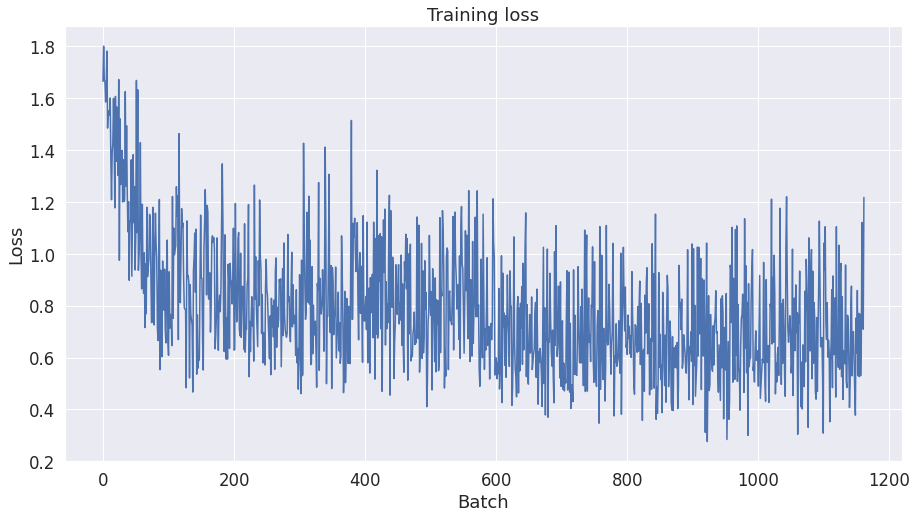

In [ ]:
# Let’s take a look at our training loss over all batches:

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
# check whole training loss
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.89,0.79,0.63,0:04:27,0:00:25
2,0.68,0.79,0.66,0:04:27,0:00:25


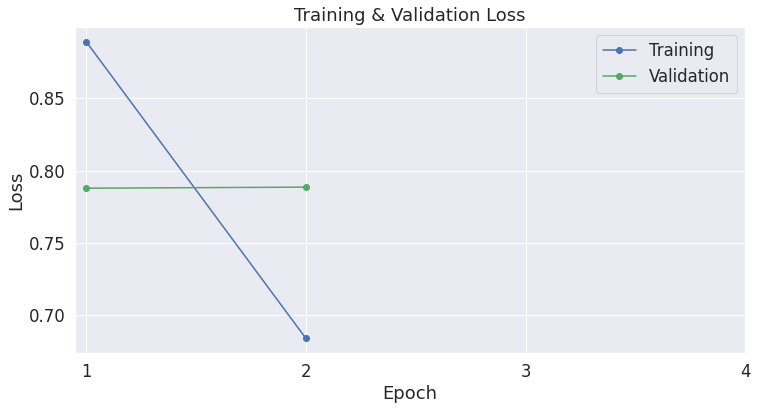

In [ ]:
# plot training vs validation loss
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#  because for this only using two epochs so replace record for further computation
record.fourth_labels = record.second_labels
record.fourth_preds = record.second_preds 

In [ ]:
# print  Confusion matrix
from sklearn.metrics import classification_report

conf_mat = classification_report(  record.fourth_labels, record.fourth_preds,) 
print( conf_mat)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       0.69      0.79      0.74       387
           2       0.54      0.37      0.44       377
           3       0.51      0.58      0.54       397
           4       0.54      0.45      0.49       405
           5       0.67      0.79      0.73       381

    accuracy                           0.66      2321
   macro avg       0.66      0.66      0.66      2321
weighted avg       0.66      0.66      0.65      2321



In [ ]:
#  for analysis check unmatched reviews
unmatch_count= 0
for actual_label, pred_label in zip(record.fourth_labels, record.fourth_preds):
  if actual_label != pred_label:
    unmatch_count += 1
    print(actual_label, pred_label)

print("not matched count", (unmatch_count/ len(record.fourth_labels)))
   


1 3
3 4
5 4
3 4
2 1
4 3
3 4
5 3
2 1
5 4
4 5
4 5
4 5
1 2
4 3
3 5
3 2
1 3
3 2
2 1
2 3
4 3
3 4
4 5
4 5
2 3
2 3
5 3
2 3
2 3
2 1
3 4
3 2
4 5
2 1
3 4
4 5
4 3
2 1
2 1
3 4
2 4
4 5
4 5
3 2
4 3
2 3
2 3
4 5
4 5
4 5
4 3
4 3
3 2
3 2
2 1
2 5
2 1
4 3
4 5
3 1
1 2
4 3
3 4
4 5
1 3
5 4
5 4
2 3
3 2
2 3
2 3
4 5
3 2
1 2
2 1
1 3
5 4
2 3
3 4
4 3
2 1
3 4
3 2
3 4
1 3
3 4
4 3
5 4
1 2
4 5
2 1
3 4
2 3
4 3
2 4
2 3
4 5
4 3
3 5
3 2
4 3
1 2
3 4
5 4
1 2
3 4
4 5
3 4
4 5
4 3
3 4
3 4
5 4
4 3
2 1
1 2
1 3
3 2
3 4
4 5
4 5
2 1
4 3
2 3
4 3
1 2
4 3
2 3
4 5
4 5
5 4
3 5
2 1
1 2
1 2
1 2
2 1
2 1
3 2
1 2
2 1
2 1
2 4
2 1
1 2
2 3
2 3
4 2
1 2
2 1
2 1
4 5
1 2
2 3
4 5
5 3
3 5
2 3
3 2
1 2
3 2
3 2
3 2
4 3
4 5
4 5
4 5
2 1
1 4
2 1
2 3
2 1
5 4
5 4
4 5
4 5
4 5
5 4
2 5
1 3
3 4
2 4
2 1
1 2
2 3
4 5
2 1
5 4
2 3
2 3
4 5
3 2
4 5
3 2
5 3
2 3
2 1
3 4
1 2
4 5
4 3
3 4
2 1
1 2
3 4
3 4
2 1
1 3
5 4
5 4
2 1
4 5
4 3
3 2
2 3
4 5
3 4
4 5
2 3
2 3
2 3
3 4
2 3
2 3
2 1
3 2
4 5
5 4
3 2
2 3
4 5
3 2
2 3
4 5
1 2
2 1
5 4
1 2
2 3
1 2
5 4
5 4
5 4
4 5
2 1
4 5
4 5
4 5
2 3


In [ ]:
from sklearn.metrics import matthews_corrcoef

print('Matthews Corr. Coef.')
matthews = matthews_corrcoef( record.fourth_labels, record.fourth_preds )        
print(matthews)

Matthews Corr. Coef.
0.5959775475015184


In [ ]:

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
import os
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/spiece.model',
 './model_save/added_tokens.json')

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "/content/drive/My Drive/Projects/Hotel_Reviews"

